# Distance Estimation and Angle Recovery

TODO: put equateions

## Content

1. [Data Preparation](Read-Data)
2. 

## Read Data

Data used:
- Protein: 5a1a (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5a1a.pdb1-500.jpg)

In [2]:
import os
import h5py
import numpy as np

import sys
sys.path.append("../../..") 
from cryoem.plots import plot_angles_count, plot_euclidean_space, save_space_plot, plot_SO3_space
from IPython.display import Image
from cryoem.angle_recovery import train_angle_recovery

import tensorflow as tf
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space
from cryoem.angle_recovery import geodesic_distance, update_angles, distance_difference, find_best_rotation
from cryoem.distance_estimation import train_siamese

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7095784233115568103
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12266746186018154254
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6369487787051213578
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3346268160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8313542596057179192
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
PROTEIN="5j0n"#"5a1a"
ROOT_DIR = "../../.."
NUM_PROJECTIONS = 5000

In [5]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


### True Angles

In [6]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

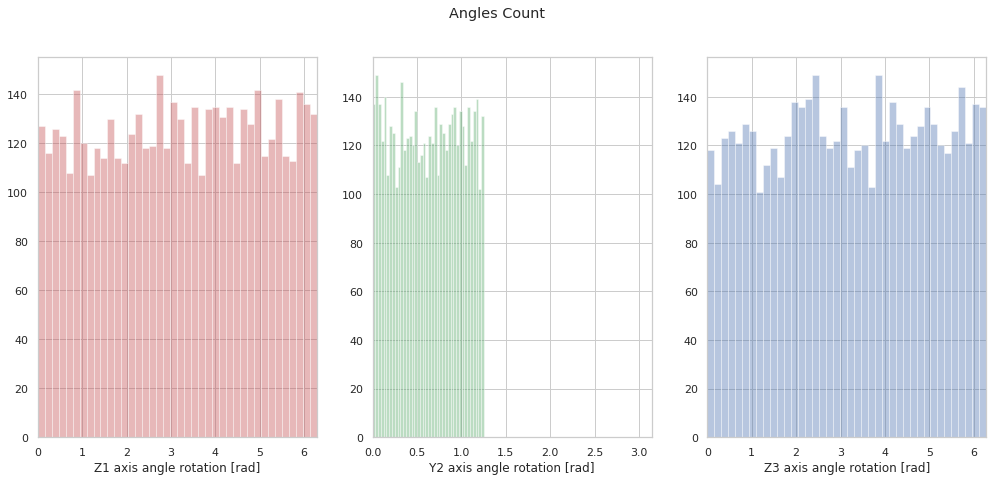

In [7]:
plot_angles_count(angles_true)

---

## Prepare for training

In [8]:
from sklearn.model_selection import train_test_split
from cryoem.distance_estimation import create_pairs

In [9]:
X, y = np.array(data['Projections'], dtype=np.float32), np.array(data['Angles'], dtype=np.float32)

In [10]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=0.33, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=0.25, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

In [11]:
# TODO: 2 problems, bigger image now it is 275 instead of 116
# and the tr_pairs bellow the number is a lot decreased

In [12]:
tr_pairs, tr_y = create_pairs(X, y, indices=train_idx, num_pairs=60000)
tr_pairs = tr_pairs.reshape(list(tr_pairs.shape) + [-1])
tr_y = tf.cast(tr_y, dtype=tf.float32)

val_pairs, val_y = create_pairs(X, y, indices=val_idx, num_pairs=20000)
val_pairs = val_pairs.reshape(list(val_pairs.shape) + [-1])
val_y = tf.cast(val_y, dtype=tf.float32)

te_pairs, te_y = create_pairs(X, y, indices=test_idx, num_pairs=20000)
te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
te_y = tf.cast(te_y, dtype=tf.float32)

# 1. Distance Estimation

### Train the model

Input images shape (116, 116, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0     

Epoch 25/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0458 - mae: 0.1708
Epoch 00025: saving model to training/20200220_005054
60000/60000 [==============================] - 183s 3ms/sample - loss: 0.0458 - mae: 0.1708 - val_loss: 0.0788 - val_mae: 0.2180
Epoch 26/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0455 - mae: 0.1704
Epoch 00026: saving model to training/20200220_005054
60000/60000 [==============================] - 183s 3ms/sample - loss: 0.0455 - mae: 0.1703 - val_loss: 0.0717 - val_mae: 0.2098
Epoch 27/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0453 - mae: 0.1697
Epoch 00027: saving model to training/20200220_005054
60000/60000 [==============================] - 182s 3ms/sample - loss: 0.0453 - mae: 0.1697 - val_loss: 0.0698 - val_mae: 0.2077
Epoch 28/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0441 - mae: 0.1673
Epoch 00028: saving model to training/20200220_005054
60000/600

59904/60000 [============================>.] - ETA: 0s - loss: 0.0410 - mae: 0.1606
Epoch 00054: saving model to training/20200220_005054
60000/60000 [==============================] - 181s 3ms/sample - loss: 0.0410 - mae: 0.1606 - val_loss: 0.0685 - val_mae: 0.2074
Epoch 55/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0400 - mae: 0.1587
Epoch 00055: saving model to training/20200220_005054
60000/60000 [==============================] - 181s 3ms/sample - loss: 0.0400 - mae: 0.1587 - val_loss: 0.0710 - val_mae: 0.2065
Epoch 56/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0401 - mae: 0.1585
Epoch 00056: saving model to training/20200220_005054
60000/60000 [==============================] - 184s 3ms/sample - loss: 0.0401 - mae: 0.1585 - val_loss: 0.0687 - val_mae: 0.2067
Epoch 57/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0393 - mae: 0.1571
Epoch 00057: saving model to training/20200220_005054
60000/60000 [=========

59904/60000 [============================>.] - ETA: 0s - loss: 0.0384 - mae: 0.1549
Epoch 00083: saving model to training/20200220_005054
60000/60000 [==============================] - 182s 3ms/sample - loss: 0.0384 - mae: 0.1549 - val_loss: 0.0736 - val_mae: 0.2088
Epoch 84/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0380 - mae: 0.1541
Epoch 00084: saving model to training/20200220_005054
60000/60000 [==============================] - 181s 3ms/sample - loss: 0.0380 - mae: 0.1540 - val_loss: 0.0726 - val_mae: 0.2074
Epoch 85/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0381 - mae: 0.1545
Epoch 00085: saving model to training/20200220_005054
60000/60000 [==============================] - 185s 3ms/sample - loss: 0.0381 - mae: 0.1545 - val_loss: 0.0745 - val_mae: 0.2086
Epoch 86/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0385 - mae: 0.1550
Epoch 00086: saving model to training/20200220_005054
60000/60000 [=========

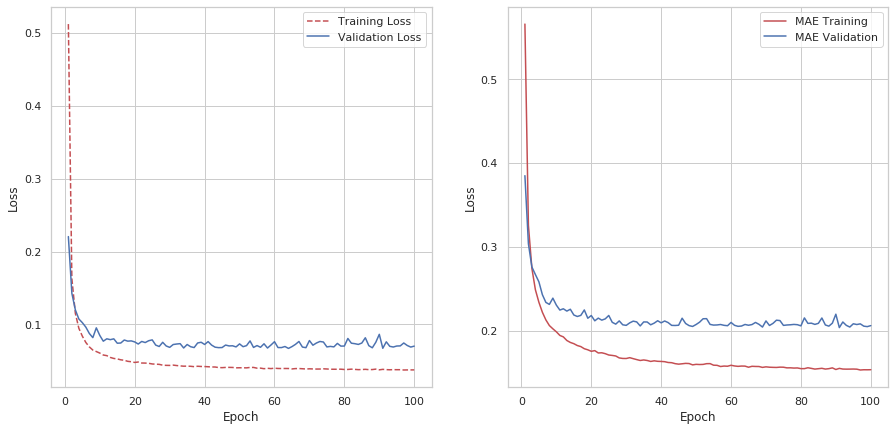

In [12]:
model = train_siamese(training_pairs=tr_pairs, 
              training_y=tr_y, 
              validation_pairs=val_pairs, 
              validation_y=val_y, 
              epochs=100, 
              batch_size=256, 
              learning_rate=0.001,
              plot=True)

### (Or) Read model checkpoint

In [13]:
# stop here, change file

In [13]:
# #model_filename = "training/20191218_023743.h5"
model_filename = "training/20200220_055622.h5"

In [14]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

### Some model results

In [15]:
from cryoem.distance_estimation import plot_results

In [16]:
y_tr_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
y_val_pred = model.predict([val_pairs[:, 0], val_pairs[:, 1]])

In [17]:
plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
plot_validation_results = plot_results(val_pairs, y_val_pred, val_y, "Validation")

--- Train Set ---
predicted: 1.9036271572113037
true:      1.6614339351654053
mse:       0.058657556772232056
mae:       0.24219322204589844


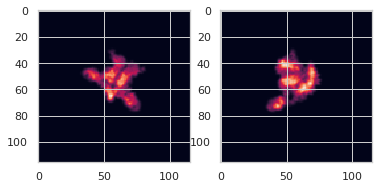

In [18]:
plot_train_results(1)

--- Validation Set ---
predicted: 2.225539207458496
true:      2.116025924682617
mse:       0.011993159539997578
mae:       0.1095132827758789


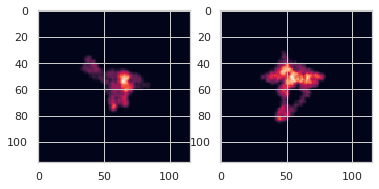

In [19]:
plot_validation_results(0)

---

## dP/dQ plot

In [20]:
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [21]:
def d_p(p1, p2):
    p1 = np.array(p1)
    p1 = p1.reshape(list(p1.shape) + [-1])
    p2 = np.array(p2)
    p2 = p2.reshape(list(p2.shape) + [-1])
    return model.predict([p1, p2])

In [22]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

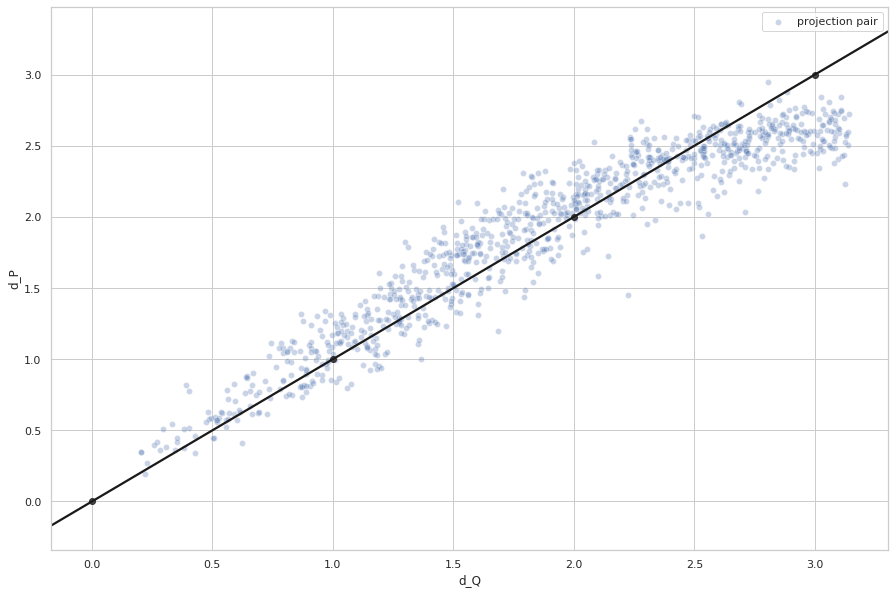

In [23]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

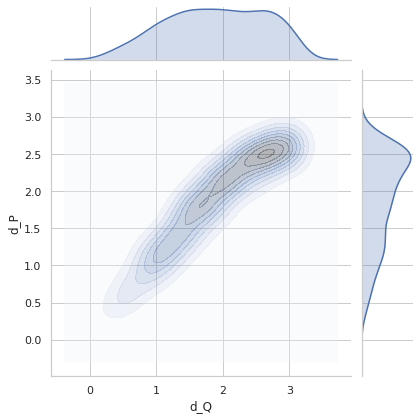

In [24]:
plot_dP_dQ_density(dP_values, dQ_values)

In [36]:
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.23646879514267355

# 2. Angle Recovery

In [24]:
from cryoem.angle_recovery import train_angle_recovery

In [25]:
num_pairs = 20000

###### Predicted Angles (initialization)

In [26]:
angle_shift = [0.0, 0.0, 0.0]
angle_coverage = [2.0, 0.4, 2.0]

low_ang = [x*np.pi for x in angle_shift]
high_ang = [x*np.pi for x in angle_coverage]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(angles_true), 3))

# angles_predicted = [tf.Variable(e, constraint=lambda x: mod_angles(x, angle_shift, angle_coverage)) for e in euler]
angles_predicted = [tf.Variable(e) for e in euler]


angles_predicted = np.array(angles_predicted)
angles_predicted.shape

(5000,)

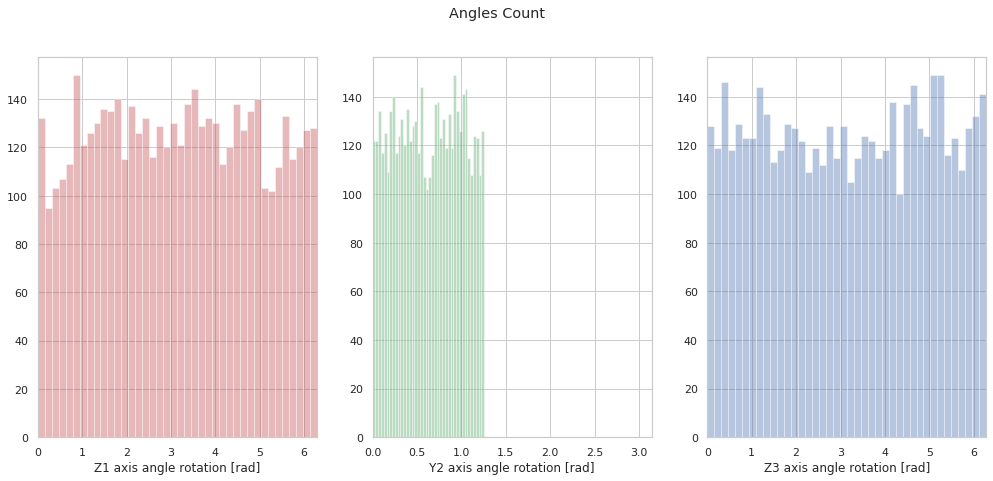

In [27]:
plot_angles_count(angles_predicted)

## Angle Recovery

Perfect distances. Learning rate 0.01

In [1]:
from cryoem.angle_recovery import train_angle_recovery

ModuleNotFoundError: No module named 'cryoem'

In [ ]:
train_angle_recovery(steps=1000, 
                     batch_size=256, 
                     projection_idx=test_idx, 
                     angles_predicted=angles_predicted, 
                     est_dist_input=X, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

step 1500/15000 (582s): loss = 8.32e-01


In [ ]:
# loss_predicted_vs_true_angle(steps=500, batch_size=256)

In [ ]:
# loss_predicted_angle_vs_projection(steps=15000, 
#                                    batch_size=512, 
#                                    optimization=True, 
#                                    angles_predicted=angles_predicted)

In [ ]:
# loss_predicted_vs_true_angle(steps=500, batch_size=256)

In [ ]:
# angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])


# fig, axs = plt.subplots(1, 3, figsize=(17,7))
# axs[0].set_xlim(0,2*np.pi)
# axs[1].set_xlim(0,np.pi)
# axs[2].set_xlim(0,2*np.pi)
# plt.suptitle("Predicted Angles Count")

# sns.distplot(angles_predicted_plot[:,0], kde=False, bins=80, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
# sns.distplot(angles_predicted_plot[:,1], kde=False, bins=80, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
# sns.distplot(angles_predicted_plot[:,2], kde=False, bins=80, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [ ]:
# # plot
# all_vectors = RotationMatrix(angles_predicted_plot)
# ipv.figure(width=500, height=500)
# ipv.pylab.xlim(-1, 1)
# ipv.pylab.ylim(-1, 1)
# ipv.pylab.zlim(-1, 1)
# ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
# #ipv.pylab.save(f"data/angle_variety/fullpl_predicted_{angle_ranges}.html")
# ipv.show()

In [ ]:
# continue here

In [ ]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])
angles_true_plot = y

all_vectors_p = RotationMatrix(angles_predicted_plot)
all_vectors_t = RotationMatrix(angles_true_plot)

In [ ]:
limit=10

In [ ]:
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors_p[:limit,0], all_vectors_p[:limit,2], all_vectors_p[:limit,1], marker="sphere", color="green", size=1)

for i in range(limit):
    connection0 = [all_vectors_p[i,0], all_vectors_t[i,0]]
    connection1 = [all_vectors_p[i,1], all_vectors_t[i,1]]
    connection2 = [all_vectors_p[i,2], all_vectors_t[i,2]]
    ipv.plot(connection0, connection2, connection1, marker="sphere", color="red", size=1)
    
ipv.scatter(all_vectors_t[:limit,0], all_vectors_t[:limit,2], all_vectors_t[:limit,1], marker="sphere", color="red", size=1)

ipv.pylab.save(f"data/angle_variety/fullpl_predicted_{angle_ranges}.html")
ipv.show()

# 3. Angle Estimation Error

The ideal metric is the mean average angle estimation error, under best alignment:
$$
\min_R \frac{1}{n} \sum_{i=1}^n \left| d_Q(Q_i, R \hat{Q}_i) \right|
$$

* $d_Q$ is the distance between two quaternions
* $Q_i$ is the true quaternion (angles, rotation)
* $\hat{Q}_i$ is the estimated quaternion (angles, rotation)
* $R$ is a quaternion representing a global rotation which best aligns the two sets of quaternions

The estimated quaternions are globally rotated as $R \hat{Q}_i$, where the multiplication (the [Hamilton product](https://en.wikipedia.org/wiki/Quaternion#Hamilton_product)) of two quaternions is the composition of the two rotations they represent.

@Jelena: you can implement it with gradient descent, in the same way we
do angle recovery. To be sure, that is the third optimization in the
pipeline (after angle recovery), whose sole purpose is to evaluate the
recovery.

Once aligned (i.e., the best R is found), plot both the true and aligned
recovered (predicted) quaternions on the same sphere. Add dashed lines
that link each true angle with the recovered one. That should make a
great visualization.

You can compute the metric and plot the visualization on the two
recovered angles you showed today.

In [ ]:
angles_predicted_final = np.zeros((NUM_PROJECTIONS, 3))
for i, ap in enumerate(angles_predicted):
    angles_predicted_final[i] = ap.numpy()
    
np.save('data/angles_predicted_final.npy', angles_predicted_final)

---

In [ ]:
def lossR(a_R, a_predicted, a_true):
    a_predicted = list(a_predicted)
    a_true = list(a_true)
    
    q_predicted = euler2quaternion(a_predicted)
    q_true = euler2quaternion(a_true)
    q_R = euler2quaternion(a_R)

    distance = d_q(q_true, quaternion.multiply(q_R, q_predicted))
    
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean(distance)

In [ ]:
def gradientR(a_R, a_predicted, a_true):
    with tf.GradientTape() as tape:
        loss_value = lossR(a_R, a_predicted, a_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient

In [ ]:
euler = np.zeros(3, dtype=np.float64)
a_R = [tf.Variable(euler)]

In [ ]:
print(f"rotation : {a_R[0].numpy()}\nloss     : {lossR(a_R, angles_predicted, y).numpy()}")

In [ ]:
loss_predicted_vs_true_angle(steps=500, batch_size=256)

In [ ]:
steps=20000
batch_size=256

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = Adam(learning_rate=0.01)

losses = np.empty(steps)
time_start = time()

for step in range(1, steps+1):

    # Sample some pairs.
    idx = list(np.random.choice(NUM_PROJECTIONS, size=batch_size))
    
    # Compute distances between projections
    a_true = [y[i] for i in idx]
    a_predicted = [angles_predicted[i] for i in idx]
    
    # Optimize by gradient descent.
    losses[step-1], gradients = gradientR(a_R, a_predicted, a_true)
    optimizer.apply_gradients(zip(gradients, a_R))

    # Periodically report progress.
    if ((step % (steps//10)) == 0) or (step == steps):
        time_elapsed = time() - time_start
        print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

# Plot convergence.
fig, ax = plt.subplots()
ax.plot(np.linspace(0, time()-time_start, steps), losses)
ax.set_xlabel('time [s]')
ax.set_ylabel('loss');

In [ ]:
print(f"rotation : {a_R[0].numpy()}\nloss     : {lossR(a_R, angles_predicted, y).numpy()}")

we have: 1.85 rad = 105 deg

we want: 10 deg = 0.17 rad

In [ ]:
# rotate to get new angles
q_predicted = euler2quaternion(angles_predicted)
q_R = euler2quaternion(a_R)
q_predicted_new = quaternion.multiply(q_predicted, q_R)

angles_predicted_new = quaternion2euler(q_predicted_new)

##### true vs. predicted vs.rotated prediction

In [ ]:
i = 0
y[i], angles_predicted[i].numpy(), angles_predicted_new[i].numpy()

In [ ]:
angles_predicted_plot_new = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted_new])
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])
angles_true_plot = y

all_vectors_p_new = RotationMatrix(angles_predicted_plot_new)
all_vectors_p = RotationMatrix(angles_predicted_plot)
all_vectors_t = RotationMatrix(angles_true_plot)

limit=10

# plot
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)

ipv.scatter(all_vectors_p[:limit,0], all_vectors_p[:limit,2], all_vectors_p[:limit,1], marker="sphere", color="blue", size=1)

for i in range(limit):
    connection0 = [all_vectors_p[i,0], all_vectors_p_new[i,0]]
    connection1 = [all_vectors_p[i,1], all_vectors_p_new[i,1]]
    connection2 = [all_vectors_p[i,2], all_vectors_p_new[i,2]]
    ipv.plot(connection0, connection2, connection1,color="green", lynestyle="--")

ipv.scatter(all_vectors_p_new[:limit,0], all_vectors_p_new[:limit,2], all_vectors_p_new[:limit,1], marker="sphere", color="green", size=1)

for i in range(limit):
    connection0 = [all_vectors_p_new[i,0], all_vectors_t[i,0]]
    connection1 = [all_vectors_p_new[i,1], all_vectors_t[i,1]]
    connection2 = [all_vectors_p_new[i,2], all_vectors_t[i,2]]
    ipv.plot(connection0, connection2, connection1, marker="sphere", color="red", size=1)

ipv.scatter(all_vectors_t[:limit,0], all_vectors_t[:limit,2], all_vectors_t[:limit,1], marker="sphere", color="red", size=1)

ipv.pylab.save(f"data/angle_variety/fullpl_predicted_{angle_ranges}.html")
ipv.show()


In [ ]:
loss_predicted_vs_true_angle(steps=500, batch_size=256, angles_predicted=angles_predicted_new)